## Imports

In [154]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery

## Constants

In [9]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"

## Basic data loading

In [10]:
train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", seed=42, sites={"K34-AMAZ"}
)
print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 969
Num validation 208
Num test 208


In [11]:
train_loader = DataLoader(train_patches, batch_size=2)

In [12]:
for i, (low_res, high_res) in enumerate(train_loader):
    print(
        f"batch {i}\n"
        f"low resolution batch shape {low_res.shape}\n"
        f"high resolution batch shape {high_res.shape}\n"
    )

    if i == 2:
        break

batch 0
low resolution batch shape torch.Size([2, 3, 128, 128])
high resolution batch shape torch.Size([2, 3, 256, 256])

batch 1
low resolution batch shape torch.Size([2, 3, 128, 128])
high resolution batch shape torch.Size([2, 3, 256, 256])

batch 2
low resolution batch shape torch.Size([2, 3, 128, 128])
high resolution batch shape torch.Size([2, 3, 256, 256])



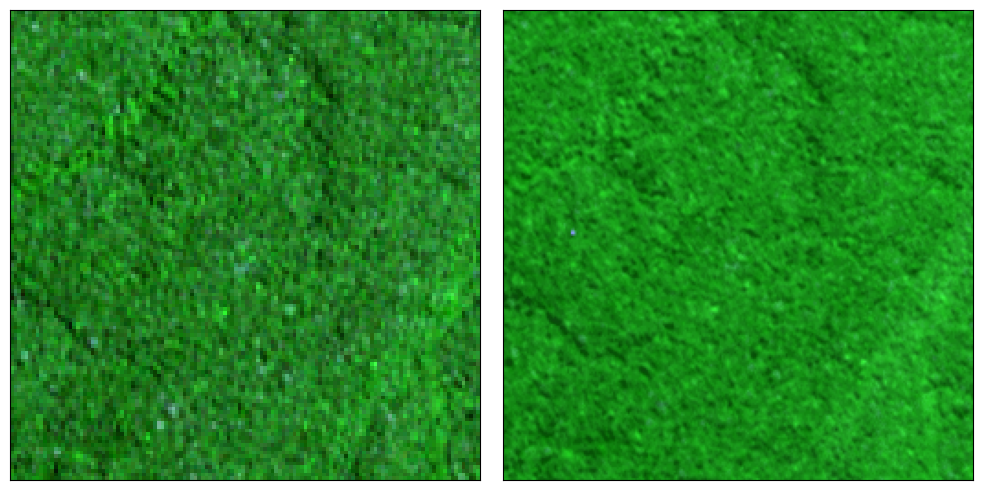

In [13]:
low_res_example = low_res[0]
high_res_example = high_res[0]
plot_gallery(
    [low_res_example.permute(1, 2, 0), high_res_example.permute(1, 2, 0)],
    xscale=5,
    yscale=5,
)

## Data loading with transforms

We often want to apply some transforms calculated from our training set and apply these
to both the training set and test sets before running data through our model. These custom transforms
are useful for training stability and normalization. This gives us another component of the model we
can experiment with if we choose.

In [ ]:
# ~2min
# Compute mean and standard deviation for each channel (averaged over samples).
train_loader = DataLoader(train_patches, batch_size=1000)

mean = 0.0
std = 0.0
for i, (low_res, high_res) in enumerate(train_loader):
    mean += torch.sum(torch.mean(low_res, (2, 3)), 0)
    mean += torch.sum(torch.mean(high_res, (2, 3)), 0)
    std += torch.sum(torch.std(low_res, (2, 3)), 0)
    std += torch.sum(torch.std(high_res, (2, 3)), 0)
num_samples = 2 * len(train_patches)
mean /= num_samples
std /= num_samples
print(f"Channel means {mean}\n" f"Channel standard deviations {std}\n")

Computing the mean and std can be slow. Here is some code for saving and loading the data.

In [9]:
save_file = PREPROCESSING_DIR / "K34-AMAZ_mean_std.pkl"

In [60]:
# with open(save_file, "wb") as file:
#     pickle.dump((mean, std), file)

In [10]:
# with open(save_file, "rb") as file:
#     mean, std = pickle.load(file)

In [33]:
def custom_transform(
    low_res_patch: torch.Tensor, high_res_patch: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    augmentations = transforms.Compose(
        [
            transforms.Normalize(mean, std),
        ]
    )

    # Basic transforms such as removing 4th channel and scaling surface reflectants
    low_res_patch, high_res_patch = default_patch_transform(
        low_res_patch, high_res_patch
    )

    # torchvision transforms expects shape (CxHxW) so permute accordingly
    low_res_patch = low_res_patch.permute(0, 2, 1)
    high_res_patch = high_res_patch.permute(0, 2, 1)
    low_res_augmented = augmentations(low_res_patch).permute(0, 2, 1)
    high_res_augmented = augmentations(high_res_patch).permute(0, 2, 1)

    return low_res_augmented, high_res_augmented

In [34]:
train_patches.set_transform(custom_transform)

Images will now be loaded with the above custom transform applied.

## Example Model

The following model does not do anything meaningful but has an input in the shape of the low 
resolution image and output in the shape of a high resolution one.

In [121]:
class ProbablyBadSR(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # Conv layers 1
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(5, 5)),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            #
            # Conv layer 2
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=(5, 5)),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            #
            # Reshape into 128x128 (no idea of what these really do)
            nn.ConvTranspose2d(in_channels=40, out_channels=3, kernel_size=(5, 5)),
            nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(5, 5)),
            # Using nearest interpolation
            nn.Upsample((256, 256)),
        )

    def forward(self, x):
        return self.net(x)

In [122]:
model = ProbablyBadSR()
print(model)

ProbablyBadSR(
  (net): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(40, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ConvTranspose2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
    (6): Upsample(size=(256, 256), mode=nearest)
  )
)


## Train Loop Example

In [138]:
NUM_EPOCHS = 1

In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=128,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=2,  # Load data in parallel but costs more memory
)

In [157]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [158]:
model = model.to(device)
model.train()

losses = []
progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
for epoch in range(NUM_EPOCHS):
    for low_res_batch, high_res_batch in progress_bar:
        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        optimizer.zero_grad()

        # Loss and update
        out = model(low_res_batch)
        loss = criterion(out, high_res_batch)
        loss.backward()
        optimizer.step()

        # Collect data
        losses.append(loss.item())
        progress_bar.set_postfix(epoch=epoch, loss=loss.item())

100%|███████████████████████████████████████████| 7/7 [02:55<00:00, 25.12s/it, epoch=0, loss=0.0179]


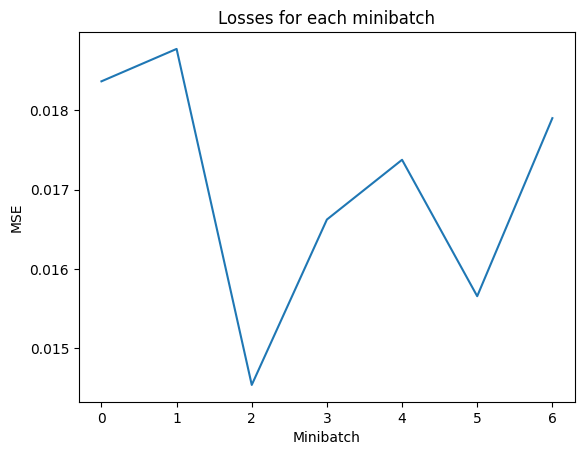

In [159]:
plt.plot(losses)
plt.title("Losses for each minibatch")
plt.xlabel("Minibatch")
plt.ylabel("MSE")
plt.show()